#  Title:                             Groupo Bimbo Inventory Demand

# Problem Statement: Predicting the demand of product for a given week, at a particular store

# Team Details







Name           Roll_num

Sunil          324

Vachana        327

Veeresh        330

Vijayalaxmi    333

In [1]:
import math
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

# Read data

In [10]:
client = pd.read_csv('client.csv')
product = pd.read_csv('product.csv')
town = pd.read_csv('town_state.csv')

#change column names for undesratnding purpose
client.columns = ['Client_ID', 'Client_name']
product.columns = ['Product_ID', 'Product_Name']
town.columns = ['Sales_Depot_ID', 'Town', 'State']

# Preprocess Client data

Check for null values in client data

In [11]:
client.isnull().values.any()

False

Drop duplicate client values

in client table some words mean not defiened

In [12]:
print(client.shape[0])
client.drop_duplicates(['Client_ID'],keep='first',inplace=True)
print(client.shape[0])

client.loc[(client['Client_name'] == 'NO IDENTIFICADO') | (client['Client_name'] == 'SIN NOMBRE') |
           (client['Client_name'] == 'INACTIVAR NO TOCAR') ,'Client_name' ] = 'NO_Name'

935362
930500


# Town-state table preprocessing

check for null values in table

In [5]:
town.isnull().values.any()

False

check for duplicate departments

In [6]:
print(town.shape[0])
town.drop_duplicates(['Sales_Depot_ID'],keep='first',inplace=True)
print(town.shape[0])

790
790


we are using regular expression to format text

repalcing space with underscore

replacing non-alphabetic values

In [13]:
town['Town'] = town['Town'].str.replace('^([^\s]+)\s', '')
town['Town'] = town['Town'].str.replace('\d+', '')
town['Town'] = town['Town'].str.replace('.','')
town['Town'] = town['Town'].str.replace(' ','_')
town['Town'] = town['Town'].str.replace('Ã\s*','AN')
town['State'] = town['State'].str.replace(',','')
town['State'] = town['State'].str.replace('.','')
town['State'] = town['State'].str.replace(' ','_')
town.head()

,Sales_Depot_ID,Town,State
0,1110,AG_LAGO_FILT,MÉXICO_DF
1,1111,AG_AZCAPOTZALCO,MÉXICO_DF
2,1112,AG_CUAUTITLAN,ESTADO_DE_MÉXICO
3,1113,AG_LAGO_FILT,MÉXICO_DF
4,1114,AGIZTAPALAPA_,MÉXICO_DF


# Preprocess Product data

In product table product name column is combined with all the other information. We have to extract all the values to correct columns.

We have used regular expressions to separate the values.

In [8]:
product.isnull().values.any()

False

In [14]:
print(product.shape[0])
product.drop_duplicates(['Product_ID'],keep='first',inplace=True)
print(product.shape[0])

2592
2592


In [15]:
id_list = product['Product_ID'].values
name_list = product['Product_Name'].values
num_product = name_list.shape[0]

product_weight_list = np.empty(num_product)
product_weight_list[:] = np.NAN
product_piece_list = np.ones(num_product)
product_brand_list = list()
product_short_name_list = list()

product_info_list = zip(id_list,name_list)

#extract weight,piece,brand and prod_name

regex_piece_weight = re.compile(r'(.*?)(\d+)(p|P).*?(\d+)\s*(kg|Kg|g|G|ml)') #check for line with piece first and then weight
regex_weight_piece = re.compile(r'(.*?)(\d+)\s*(kg|Kg|g|G|ml).*?(\d+)(p|P)') #opp of first
regex_weight = re.compile(r'(.*?)(\d+)\s*(kg|Kg|g|G|ml)')  #line with only weights
regex_piece = re.compile(r'(.*?)(\d+)(p|P)(?!ct|CT)')  #line with only piece

dont_know_list = ['MTB', 'MTA', 'TNB', 'CU', 'TAB']

for i, (product_id, orig_product_name) in enumerate(product_info_list):
    product_name = orig_product_name.rstrip(str(product_id)).strip()
    
    product_name_words = product_name.split()   
    
    if re.search(regex_piece_weight, product_name):
        regex_result = re.search(regex_piece_weight, product_name)
        product_weight_list[i] = float(regex_result.group(4))
        product_piece_list[i] = int(regex_result.group(2))
        product_short_name = regex_result.group(1)
        if regex_result.group(5) == 'kg' or regex_result.group(5) == 'Kg':       #replace kg values with gram
            product_weight_list[i] *= 1000
            
    elif re.search(regex_weight_piece, product_name):
        regex_result = re.search(regex_weight_piece, product_name)
        product_weight_list[i] = float(regex_result.group(2))
        product_piece_list[i] = int(regex_result.group(4))
        if regex_result.group(3) == 'kg' or regex_result.group(3) == 'Kg': 
            product_weight_list[i] *= 1000
        product_short_name = regex_result.group(1)
        
    elif re.search(regex_weight, product_name):
        regex_result = re.search(regex_weight, product_name)
        product_weight_list[i] = float(regex_result.group(2))
        if regex_result.group(3) == 'kg' or regex_result.group(3) == 'Kg':
            product_weight_list[i] *= 1000
        product_short_name = regex_result.group(1)
        
    elif re.search(regex_piece, product_name):
        regex_result = re.search(regex_piece, product_name)
        product_piece_list[i] = int(regex_result.group(2))
        product_short_name = regex_result.group(1) 
        
        #After separating out values ,still there are some values attached with product name.Remove them
    else:
        product_short_name = ' '.join([word for word in product_name_words[:-1] if word not in dont_know_list])
        
    product_brand_list.append(product_name_words[-1])
    product_short_name_list.append(product_short_name)
    
product['product_name'] = product_short_name_list
product['brand'] = product_brand_list
product['weight'] = product_weight_list
product['pieces'] = product_piece_list

product.drop('Product_Name',axis = 1,inplace=True)
product.head()

,Product_ID,product_name,brand,weight,pieces
0,0,NO,IDENTIFICADO,NaN,1.0
1,9,Capuccino Moka,NES,750.0,1.0
2,41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0
3,53,Burritos Sincro,LON,170.0,1.0
4,72,Div Tira Mini Doradita,TR,45.0,4.0


In [10]:
P = product[['weight','pieces']]
P.describe()

,weight,pieces
count,2541.000000,2592.000000
mean,413.480913,6.520448
std,1764.304179,13.941169
min,4.000000,0.000000
25%,80.000000,1.000000
50%,180.000000,1.000000
75%,400.000000,8.000000
max,42000.000000,200.000000


Repalce weight with median values. Because some weight values are very high,which increases mean value.

In [16]:
product['weight'].fillna(80,inplace=True)
product.head()

,Product_ID,product_name,brand,weight,pieces
0,0,NO,IDENTIFICADO,80.0,1.0
1,9,Capuccino Moka,NES,750.0,1.0
2,41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0
3,53,Burritos Sincro,LON,170.0,1.0
4,72,Div Tira Mini Doradita,TR,45.0,4.0


For mining we have directly selected week,dept_id,client,product  combination.

Because we predicting adjusted demand for each client of for a given week and product.

Graph diplay product weight desctribution

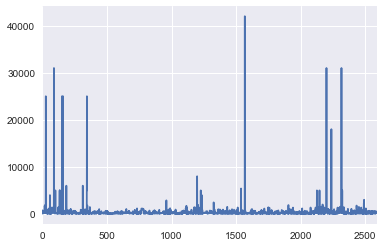

In [5]:
product['weight'].plot()
plt.show()

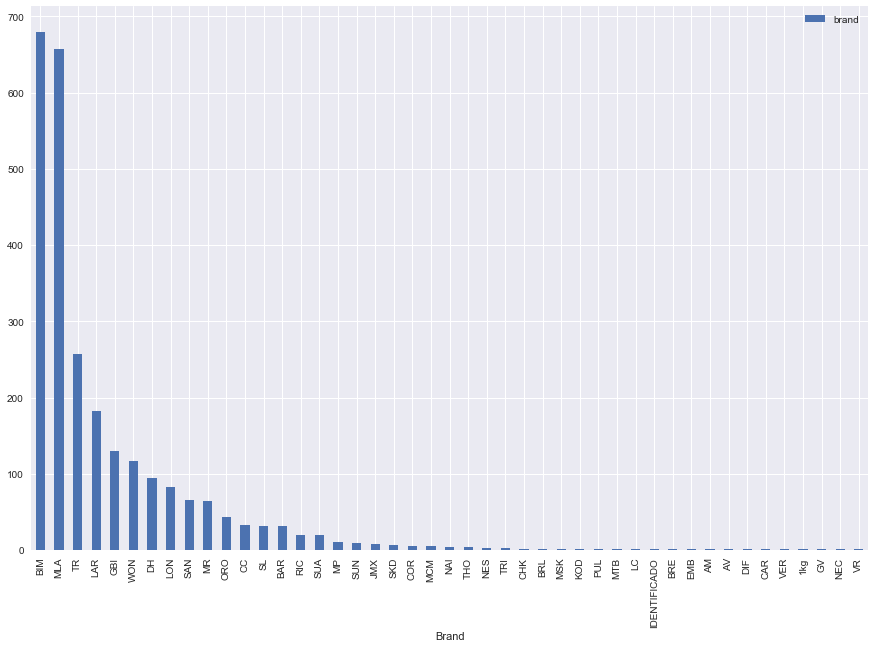

In [6]:
df=product['brand'].value_counts()
df.plot(kind='bar', legend=True,figsize=(15,10))
plt.xlabel('Brand')
sns.despine()

In [17]:
train = pd.read_csv('train.csv',nrows=22174800,header = 0,index_col=None,usecols=[0,1,4,5,6,8,10],
                    dtype={'Semana':np.uint8,'Agencia_ID':np.uint16,'Cliente_ID':np.uint16,'Producto_ID':np.uint16,
                    'Venta_uni_hoy':np.uint32,'Dev_uni_proxima':np.uint32,'Demanda_uni_equil':np.uint32})

train.columns =['Week_number','Sales_Depot_ID','Client_ID','Product_ID','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand']
train.head()

,Week_number,Sales_Depot_ID,Client_ID,Product_ID,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand
0,3,1110,15766,1212,3,0,3
1,3,1110,15766,1216,4,0,4
2,3,1110,15766,1238,4,0,4
3,3,1110,15766,1240,4,0,4
4,3,1110,15766,1242,3,0,3


Check for any minssing values in any of the tuples.

In [13]:
train.isnull().values.any()

False

Check for duplicate values considering all features.

In [18]:
print(train.shape[0])
orginal = train.shape[0]
train.drop_duplicates(subset=['Week_number','Sales_Depot_ID','Client_ID','Product_ID','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand'],keep='first', inplace=True)
print(train.shape[0])
duplicate = orginal-train.shape[0]

percentage = (duplicate/orginal)*100
print("Duplicate Percentage :",percentage)

22174800
22149427
Duplicate Percentage : 0.11442267799484099


In some tuples returned units are greater than sales units,which is not possible.
We can't drop such columns, because such tuples contains unique set of attributes, droping may affect predicting values for such 
features.
In such tuples swap the values.

Repalce the 0 values in adjusted column with the difference between the sales unit and returned unit.

In [19]:
print(train.loc[train['Returns_unit_next_week'] > train['Sales_unit_this_week']].shape[0])
print(train['Adjusted_Demand'].loc[train['Adjusted_Demand'] ==0].count())

train.loc[train['Returns_unit_next_week'] > train['Sales_unit_this_week'],['Sales_unit_this_week', 'Returns_unit_next_week']]= \
train.loc[train['Returns_unit_next_week'] > train['Sales_unit_this_week'],['Returns_unit_next_week','Sales_unit_this_week']].values

train['Diff']=train['Sales_unit_this_week']-train['Returns_unit_next_week']
train.loc[(train['Adjusted_Demand'] == 0) & (train['Sales_unit_this_week'] != train['Returns_unit_next_week']),['Adjusted_Demand','Diff']] = \
train.loc[(train['Adjusted_Demand'] == 0) & (train['Sales_unit_this_week'] != train['Returns_unit_next_week']),['Diff','Adjusted_Demand']].values
train.drop(['Diff'],axis=1,inplace=True)
train.head()

167915
361350


,Week_number,Sales_Depot_ID,Client_ID,Product_ID,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand
0,3,1110,15766,1212,3,0,3
1,3,1110,15766,1216,4,0,4
2,3,1110,15766,1238,4,0,4
3,3,1110,15766,1240,4,0,4
4,3,1110,15766,1242,3,0,3


In [20]:
train =pd.merge(train,client,how='inner',on='Client_ID')
train =pd.merge(train,town,how='inner',on='Sales_Depot_ID')
train.drop(['Client_ID','Sales_Depot_ID','State'],axis=1,inplace=True)
train =pd.merge(train,product,how='inner',on='Product_ID') 
train.drop(['Product_ID','brand','weight','pieces'],axis=1,inplace=True)
train.shape

(9140910, 7)

In [21]:
train1 = pd.read_csv('train.csv',skiprows=range(1,22174801),nrows=31190083,header = 0,index_col=None,usecols=[0,1,4,5,6,8,10],
                    dtype={'Semana':np.uint8,'Agencia_ID':np.uint16,'Cliente_ID':np.uint16,'Producto_ID':np.uint16,
                    'Venta_uni_hoy':np.uint32,'Dev_uni_proxima':np.uint32,'Demanda_uni_equil':np.uint32})

train1.columns =['Week_number','Sales_Depot_ID','Client_ID','Product_ID','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand']
train1.head()

,Week_number,Sales_Depot_ID,Client_ID,Product_ID,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand
0,5,1110,15766,1212,5,0,5
1,5,1110,15766,1216,3,0,3
2,5,1110,15766,1220,3,0,3
3,5,1110,15766,1238,1,0,1
4,5,1110,15766,1242,2,0,2


In [18]:
train1.isnull().values.any()

False

In [22]:
print(train1.shape[0])
orginal = train1.shape[0]
train1.drop_duplicates(subset=['Week_number','Sales_Depot_ID','Client_ID','Product_ID','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand'],keep='first', inplace=True)
print(train1.shape[0])
duplicate = orginal-train1.shape[0]

percentage = (duplicate/orginal)*100
print("Duplicate Percentage :",percentage)

31190083
31156351
Duplicate Percentage : 0.10814976029400114


In [23]:
print(train1.loc[train1['Returns_unit_next_week'] > train1['Sales_unit_this_week']].shape[0])
print(train1['Adjusted_Demand'].loc[train1['Adjusted_Demand'] ==0].count())

train1.loc[train1['Returns_unit_next_week'] > train1['Sales_unit_this_week'],['Sales_unit_this_week', 'Returns_unit_next_week']]= \
train1.loc[train1['Returns_unit_next_week'] > train1['Sales_unit_this_week'],['Returns_unit_next_week','Sales_unit_this_week']].values

train1['Diff']=train1['Sales_unit_this_week']-train1['Returns_unit_next_week']
train1.loc[(train1['Adjusted_Demand'] == 0) & (train1['Sales_unit_this_week'] != train1['Returns_unit_next_week']),['Adjusted_Demand','Diff']] = \
train1.loc[(train1['Adjusted_Demand'] == 0) & (train1['Sales_unit_this_week'] != train1['Returns_unit_next_week']),['Diff','Adjusted_Demand']].values
train1.drop(['Diff'],axis=1,inplace=True)
train1.head()

248584
553590


,Week_number,Sales_Depot_ID,Client_ID,Product_ID,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand
0,5,1110,15766,1212,5,0,5
1,5,1110,15766,1216,3,0,3
2,5,1110,15766,1220,3,0,3
3,5,1110,15766,1238,1,0,1
4,5,1110,15766,1242,2,0,2


In [24]:
train1 =pd.merge(train1,client,how='inner',on='Client_ID')
train1 =pd.merge(train1,town,how='inner',on='Sales_Depot_ID')
train1.drop(['Client_ID','Sales_Depot_ID','State'],axis=1,inplace=True)
train1 =pd.merge(train1,product,how='inner',on='Product_ID') 
train1.drop(['Product_ID','brand','weight','pieces'],axis=1,inplace=True)
train1.shape

(12860050, 7)

In [25]:
train = pd.concat((train,train1), axis=0,ignore_index=True)
print(train.shape[0])
train.head()

22000960


,Week_number,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand,Client_name,Town,product_name
0,3,3,0,3,PUESTO DE PERIODICOS LAZARO,AG_LAGO_FILT,Roles Canela
1,4,4,0,4,PUESTO DE PERIODICOS LAZARO,AG_LAGO_FILT,Roles Canela
2,3,2,0,2,TOMAS GARCIA GUADARRAMA,AG_LAGO_FILT,Roles Canela
3,4,2,0,2,TOMAS GARCIA GUADARRAMA,AG_LAGO_FILT,Roles Canela
4,3,2,0,2,ESCUELA CENTRO EDUCATIVO URUAPAN,AG_LAGO_FILT,Roles Canela


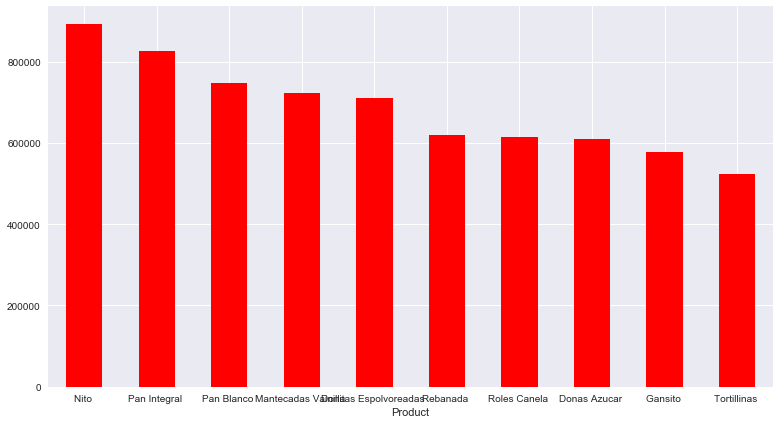

In [28]:
t = train[['product_name']]
t = t.product_name.value_counts(sort=True)
t.head(10).plot(kind='bar', color='red', rot=0,figsize=(13,7))
plt.xlabel('Product')
sns.despine()
del t

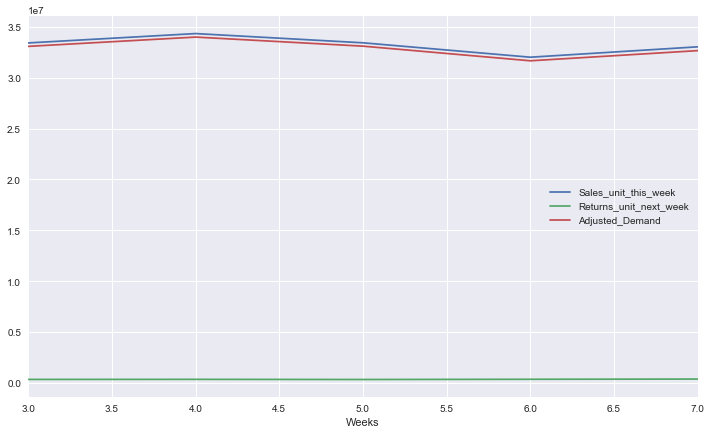

In [51]:
train1 = train[['Week_number','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand']]
x =train1.groupby(['Week_number']).sum()
x.plot(kind='line', legend=True,figsize=(12,7))
plt.xlabel('Weeks')
sns.despine()

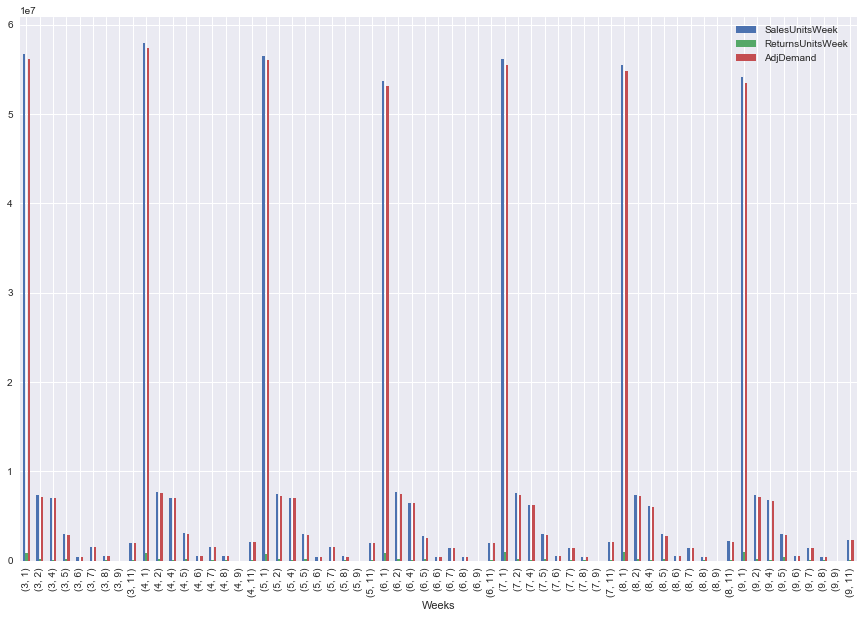

In [14]:
df_train = pd.read_csv('train.csv',usecols=[0,2,6,8,10],dtype={'Semana':int,'Canal_ID':int,'Venta_uni_hoy':int,'Dev_uni_proxima':int,'Demanda_uni_equil':int})
df_train.columns =['WeekNum','ChannelId','SalesUnitsWeek','ReturnsUnitsWeek','AdjDemand']
y=df_train.groupby(['WeekNum','ChannelId']).sum()
y.plot(kind='bar', legend=True,figsize=(15,10))
plt.xlabel('Weeks')
sns.despine()
del df_train

In [26]:
test = pd.read_csv('train.csv',skiprows=range(1,53364884),header = 0,index_col=None,usecols=[0,1,4,5,6,8,10],
                     dtype={'Semana':np.uint8,'Agencia_ID':np.uint16,'Cliente_ID':np.uint16,'Producto_ID':np.uint16,
                    'Venta_uni_hoy':np.uint32,'Dev_uni_proxima':np.uint32,'Demanda_uni_equil':np.uint32})

test.columns =['Week_number','Sales_Depot_ID','Client_ID','Product_ID','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand']
test.head()

,Week_number,Sales_Depot_ID,Client_ID,Product_ID,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand
0,8,1110,15766,1212,4,0,4
1,8,1110,15766,1216,5,0,5
2,8,1110,15766,1220,1,0,1
3,8,1110,15766,1238,3,0,3
4,8,1110,15766,1240,2,0,2


In [26]:
test.isnull().values.any()

False

In [27]:
print(test.shape[0])
orginal = test.shape[0]
test.drop_duplicates(subset=['Week_number','Sales_Depot_ID','Client_ID','Product_ID','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand'],keep='first', inplace=True)
print(test.shape[0])
duplicate = orginal-test.shape[0]

percentage = (duplicate/orginal)*100
print("Duplicate Percentage :",percentage)

20815581
20793202
Duplicate Percentage : 0.1075108112523979


In [28]:
print(test.loc[test['Returns_unit_next_week'] > test['Sales_unit_this_week']].shape[0])
print(test['Adjusted_Demand'].loc[test['Adjusted_Demand'] ==0].count())

test.loc[test['Returns_unit_next_week'] > test['Sales_unit_this_week'],['Sales_unit_this_week', 'Returns_unit_next_week']]= \
test.loc[test['Returns_unit_next_week'] > test['Sales_unit_this_week'],['Returns_unit_next_week','Sales_unit_this_week']].values

test['Diff']=test['Sales_unit_this_week']-test['Returns_unit_next_week']
test.loc[(test['Adjusted_Demand'] == 0) & (test['Sales_unit_this_week'] != test['Returns_unit_next_week']),['Adjusted_Demand','Diff']] = \
test.loc[(test['Adjusted_Demand'] == 0) & (test['Sales_unit_this_week'] != test['Returns_unit_next_week']),['Diff','Adjusted_Demand']].values
test.drop(['Diff'],axis=1,inplace=True)
test.head()

198967
421460


,Week_number,Sales_Depot_ID,Client_ID,Product_ID,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand
0,8,1110,15766,1212,4,0,4
1,8,1110,15766,1216,5,0,5
2,8,1110,15766,1220,1,0,1
3,8,1110,15766,1238,3,0,3
4,8,1110,15766,1240,2,0,2


In [29]:
test =pd.merge(test,client,how='inner',on='Client_ID')
test =pd.merge(test,town,how='inner',on='Sales_Depot_ID')
test.drop(['Client_ID','Sales_Depot_ID','State'],axis=1,inplace=True)
test =pd.merge(test,product,how='inner',on='Product_ID') 
test.drop(['Product_ID','brand','weight','pieces'],axis=1,inplace=True)
test.shape

(8582518, 7)

In [30]:
test.head()

,Week_number,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand,Client_name,Town,product_name
0,8,4,0,4,PUESTO DE PERIODICOS LAZARO,AG_LAGO_FILT,Roles Canela
1,9,1,0,1,PUESTO DE PERIODICOS LAZARO,AG_LAGO_FILT,Roles Canela
2,8,2,0,2,TOMAS GARCIA GUADARRAMA,AG_LAGO_FILT,Roles Canela
3,9,3,0,3,TOMAS GARCIA GUADARRAMA,AG_LAGO_FILT,Roles Canela
4,9,2,0,2,DON NICO,AG_LAGO_FILT,Roles Canela


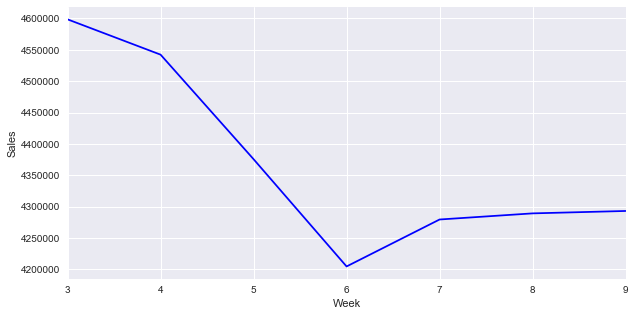

In [50]:
t = train[['Week_number']]
t1= test[['Week_number']]
t = pd.concat((t,t1), axis=0,ignore_index=True)
t.Week_number.value_counts(sort=False).plot(kind='line', color='blue', rot=0,figsize=(10,5))
plt.xlabel('Week')
plt.ylabel('Sales')
sns.despine()
del t,t1

From graph we see there is a decrease in the sale from 4th week onwards, and slight increase from 7th week onwards

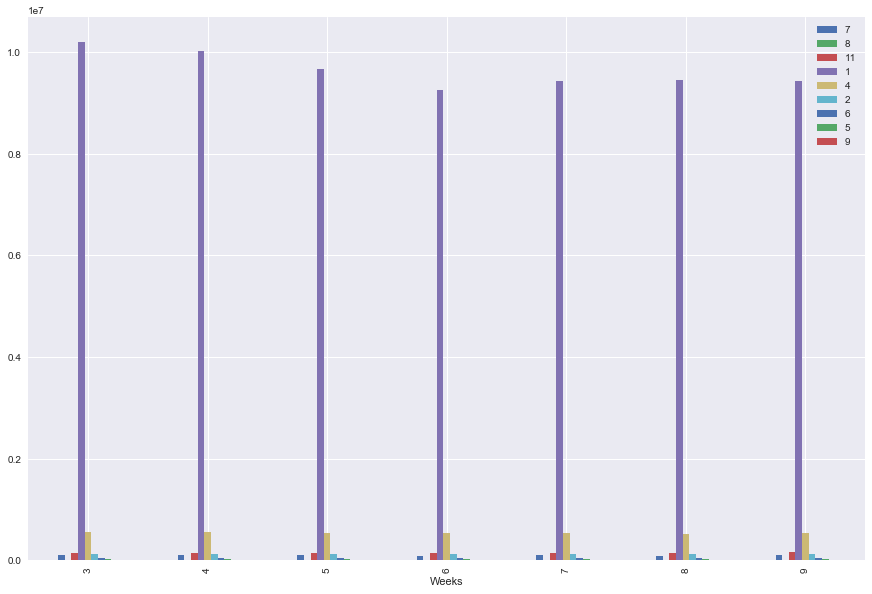

In [25]:
t = pd.read_csv('train.csv',usecols=[0,2],dtype={'Semana':'int32','Canal_ID':'int32'})
list1 = list(t['Semana'].drop_duplicates())
list2 = list(t['Canal_ID'].drop_duplicates())
dev_sin = pd.DataFrame()
dev_sin['Semana']=list1
for x in list2:
    sin=[]
    for y in list1:
        occ = t.loc[(t['Semana'] == y ) & (t['Canal_ID'] == x)].Canal_ID.count()
        sin.append(occ)
    dev_sin[x]=sin
    
dev_sin.set_index('Semana',inplace=True)
dev_sin.plot(kind='bar', legend=True,figsize=(15,10))
plt.xlabel('Weeks')
sns.despine()
del dev_sin
del t

In [30]:
train1 = pd.concat((train,test), axis=0,ignore_index=True)
train1.shape

(30583478, 7)

Transformation of Product_name and Client_name

In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [34]:
train1['Client_name'] = le.fit_transform(train1['Client_name'])
train1['product_name'] = le.fit_transform(train1['product_name'])
train1['Town'] = le.fit_transform(train1['Town'])
train1.head()

,Week_number,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand,Client_name,Town,product_name
0,3,3,0,3,14953,25,484
1,4,4,0,4,14953,25,484
2,3,2,0,2,17415,25,484
3,4,2,0,2,17415,25,484
4,3,2,0,2,6355,25,484


In [35]:
train = train1.loc[train1['Week_number']<8]
train.shape

(22000960, 7)

In [36]:
test = train1.loc[train1['Week_number']>7]
test.shape

(8582518, 7)

In [37]:
train.to_csv('Pre_train.csv',index=False,header=True)

In [38]:
test.to_csv('Pre_test.csv',index=False,header=True)

In [4]:
lag3_5 = train.loc[(train['Week_number']==3) | (train['Week_number']==4),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_5=lag3_5.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_5['week']=5
lag3_5.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_5.shape[0]

5487745

In [5]:
lag3_6 = train.loc[(train['Week_number']==3) | (train['Week_number']==4) | (train['Week_number']==5),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_6=lag3_6.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_6['week']=6
lag3_6.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_6.shape[0]

6602773

In [6]:
lag3_5 = pd.concat((lag3_5,lag3_6), axis=0,ignore_index=True)
lag3_5.shape[0]

12090518

In [7]:
lag3_6 = train.loc[(train['Week_number']==4) | (train['Week_number']==5) | (train['Week_number']==6),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_6=lag3_6.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_6['week']=7
lag3_6.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_6.shape[0]

6455119

In [8]:
lag3_5 = pd.concat((lag3_5,lag3_6), axis=0,ignore_index=True)
lag3_5.shape[0]

18545637

In [9]:
train = train.loc[train['Week_number'] >4]
train.shape

(12860050, 7)

In [11]:
train = pd.merge(lag3_5,train,how='left',on=['Week_number','Client_name','product_name','Town'])
train.shape

(19496024, 8)

In [12]:
train.isnull().values.any()

True

In [16]:
train[pd.isnull(train['Sales_unit_this_week'])].head()

,Client_name,product_name,Town,mean_sales,Week_number,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand
4,5120,484,25,2.5,5,NaN,NaN,NaN
7,13487,484,25,2.0,5,NaN,NaN,NaN
8,6915,484,25,2.0,5,NaN,NaN,NaN
14,12963,484,25,2.0,5,NaN,NaN,NaN
16,9005,484,25,2.0,5,NaN,NaN,NaN


In [20]:
train.fillna(value=0,inplace=True)

In [21]:
train.isnull().values.any()

False

In [22]:
lag3_6 = train.loc[(train['Week_number']==5) | (train['Week_number']==6) | (train['Week_number']==7),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_6=lag3_6.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_6['week']=8
lag3_6.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_6.shape[0]

7331219

In [23]:
lag3_5 = train.loc[(train['Week_number']==6) | (train['Week_number']==7),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_7= test.loc[(test['Week_number']==8),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_7 = pd.concat((lag3_5,lag3_7), axis=0,ignore_index=True)
lag3_7=lag3_7.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_7['week']=9
lag3_7.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_7.shape[0]

8162838

In [24]:
lag3_6 = pd.concat((lag3_6,lag3_7), axis=0,ignore_index=True)
lag3_6.shape[0]

15494057

In [25]:
test = pd.merge(lag3_6,test,how='left',on=['Week_number','Client_name','product_name','Town'])
test.shape

(16146346, 8)

In [26]:
test[pd.isnull(test['Sales_unit_this_week'])].head()

,Client_name,product_name,Town,mean_sales,Week_number,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand
2,6355,484,25,1.666667,8,NaN,NaN,NaN
3,103,484,25,3.333333,8,NaN,NaN,NaN
4,5120,484,25,0.000000,8,NaN,NaN,NaN
6,7846,484,25,0.666667,8,NaN,NaN,NaN
7,13487,484,25,1.000000,8,NaN,NaN,NaN


In [27]:
test.fillna(value=0,inplace=True)
test.isnull().values.any()

False

# LEARNING MODELS

Choice of the algorithm depends on the

-the size of the training data

-the number of features

-the quality of the features

Select data upto 7 weeks as training data

In [28]:
y_train = train['Adjusted_Demand']
x_train = train.drop('Adjusted_Demand',axis=1)

Select data 8-9 week as test data

In [29]:
y_test = test['Adjusted_Demand']
x_test = test.drop('Adjusted_Demand',axis=1)

## Multiple linear regression model

In [30]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

clf.fit(x_train, y_train)
prediction = clf.predict(x_test).astype(int)

In [31]:
clf.coef_

array([  5.65533483e-18,  -1.35450742e-16,  -1.98607433e-16,
        -3.43049407e-14,   3.53791416e-15,   1.00000000e+00,
        -1.00000000e+00])

In [32]:
print("RMSE: %.2f" % math.sqrt(np.mean((prediction - y_test) ** 2)))

RMSE: 0.26


Find the R_square value

In [33]:
from sklearn.metrics import r2_score
r2_score(y_test,prediction)

0.99976490098430704

Since r_square value is near to 1.0 we can say that this model is predicting good values

In [36]:
import xgboost

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [41]:
xgb = xgboost.XGBRegressor(n_estimators=100,learning_rate=0.1,gamma=0,subsample=0.75,colsample_bytree=1,max_depth=5)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [42]:
prediction = xgb.predict(x_test).astype(int)

In [43]:
print("RMSE: %.2f" % math.sqrt(np.mean((prediction - y_test) ** 2)))

RMSE: 7.20


In [45]:
r2_score(y_test,prediction)

0.8199302132015609